In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise, RepeatVector, Permute
from keras.layers import GRU, Bidirectional, TimeDistributed, Multiply, Lambda
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [3]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [5]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 19.2 s


In [6]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 385 ms


In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("w2v2_modregex.w2v")

2020-05-01 12:18:44,424 : INFO : loading Word2Vec object from w2v2_modregex.w2v
2020-05-01 12:18:45,012 : INFO : loading wv recursively from w2v2_modregex.w2v.wv.* with mmap=None
2020-05-01 12:18:45,012 : INFO : loading vectors from w2v2_modregex.w2v.wv.vectors.npy with mmap=None
2020-05-01 12:18:45,327 : INFO : setting ignored attribute vectors_norm to None
2020-05-01 12:18:45,328 : INFO : loading vocabulary recursively from w2v2_modregex.w2v.vocabulary.* with mmap=None
2020-05-01 12:18:45,329 : INFO : loading trainables recursively from w2v2_modregex.w2v.trainables.* with mmap=None
2020-05-01 12:18:45,330 : INFO : loading syn1neg from w2v2_modregex.w2v.trainables.syn1neg.npy with mmap=None
2020-05-01 12:18:45,647 : INFO : setting ignored attribute cum_table to None
2020-05-01 12:18:45,648 : INFO : loaded w2v2_modregex.w2v


In [10]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 152070


In [11]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [12]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274081 unique tokens.


In [13]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [14]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [35]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=True)

In [36]:
#attention from https://github.com/keras-team/keras/issues/4962
from keras import backend as K

sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attention_word=Dense(1, activation='tanh')(lstm_word)
attention_word=Flatten()(attention_word)
attention_word=Activation('softmax')(attention_word)
attention_word=RepeatVector(50*2)(attention_word)
attention_word=Permute((2, 1))(attention_word)
word_representation = Multiply()([lstm_word, attention_word])
word_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(50*2,))(word_representation)
sentenceEncoder = Model(sentence_input, word_representation)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attention_sent=Dense(1, activation='tanh')(lstm_sentence)
attention_sent=Flatten()(attention_sent)
attention_sent=Activation('softmax')(attention_sent)
attention_sent=RepeatVector(50*2)(attention_sent)
attention_sent=Permute((2, 1))(attention_sent)
sent_representation = Multiply()([lstm_sentence, attention_sent])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(50*2,))(sent_representation)
preds = Dense(5, activation='softmax')(sent_representation)
model = Model(review_input, preds)

In [37]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 15, 100)      0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 15, 100)      54891801    input_20[0][0]                   
__________________________________________________________________________________________________
bidirectional_24 (Bidirectional (None, 15, 100)      45300       time_distributed_2[0][0]         
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 15, 1)        101         bidirectional_24[0][0]           
___________________________________________________________________________________________

In [38]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [39]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3976s 8ms/step - loss: 1.0105 - acc: 0.5522 - val_loss: 0.8735 - val_acc: 0.6155
Epoch 2/10
520000/520000 [==============================] - 4055s 8ms/step - loss: 0.8927 - acc: 0.6047 - val_loss: 0.8287 - val_acc: 0.6368
Epoch 3/10
520000/520000 [==============================] - 4057s 8ms/step - loss: 0.8628 - acc: 0.6189 - val_loss: 0.8091 - val_acc: 0.6462
Epoch 4/10
520000/520000 [==============================] - 4058s 8ms/step - loss: 0.8449 - acc: 0.6278 - val_loss: 0.8055 - val_acc: 0.6466
Epoch 5/10
520000/520000 [==============================] - 4054s 8ms/step - loss: 0.8325 - acc: 0.6336 - val_loss: 0.7855 - val_acc: 0.6588
Epoch 6/10
520000/520000 [==============================] - 4061s 8ms/step - loss: 0.8220 - acc: 0.6378 - val_loss: 0.8085 - val_acc: 0.6433
Epoch 7/10
520000/520000 [==============================] - 4058s 8ms/step - loss: 0.8134 - acc: 0.642

In [40]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 109s 2ms/step

ACCURACY: 0.6396399736404419
LOSS: 0.823739954829216
Wall time: 1min 49s


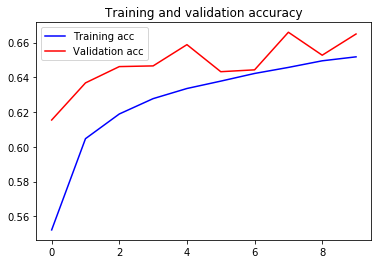

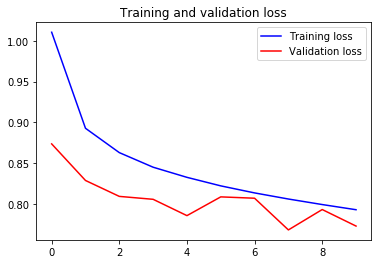

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [42]:
model.save("hatn_yelp2_modregex_customattention.h5")
pickle.dump(tokenizer, open("tokenizer2_modregex_customattention.pkl", "wb"), protocol=0)

In [4]:
from keras.models import load_model

model = load_model("hatn_yelp2_modregex_customattention.h5")
tokenizer = None
with open('tokenizer2_modregex_customattention.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-03 08:11:32,767 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-03 08:11:39,778 : WARNING : From C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [5]:
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence

def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    texts = []
    reviews = []
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                        
    ynew = model.predict(data)
    return ynew

In [6]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00614761 0.00932677 0.05648749 0.22676112 0.701277  ]]
5


In [7]:
text = "the restaurant we went yesterday was awful.\nThe food was bad, the service was bad."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[8.8975543e-01 1.0663279e-01 3.5194431e-03 7.5205535e-05 1.7139128e-05]]
1


In [8]:
text = "The characters in this novel were great. I immediately started rooting for them to succeed. With a shorter Nov the development of the characters were good. It would have been nice to get more background on them but again, short novel means minimal background."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00108691 0.01732791 0.34551784 0.44741172 0.1886557 ]]
4


In [9]:
text = "Good concept but I couldn't get swept away in the story. I didn't care for the characters. Events felt disjointed. I'm not sure if it was the story or the writing style, this one just wasn't for me."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.1170773  0.5858337  0.29026836 0.00619887 0.00062179]]
2


In [11]:
text = "So far... the worst book I ever read. Started out alright, but everything went downhill the moment the MC discovered his superpowers and became perhaps the biggest Gary Sue (Male counterpart to the Mary Sue) in all of published fiction."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[9.4126600e-01 5.1465858e-02 3.1921533e-03 6.4891251e-04 3.4270328e-03]]
1


In [12]:
text = "The book is straight up awful and you can't change mind"
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.6826508  0.17673048 0.06433566 0.0239076  0.05237544]]
1


Text(0.5, 1.0, 'Dataset labels distribuition')

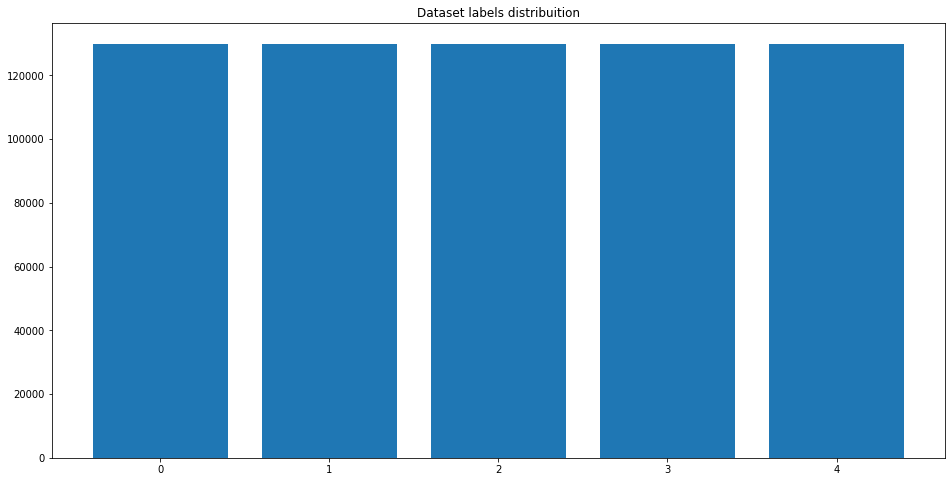

In [50]:
target_cnt = Counter(df_train.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [54]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [56]:
label_names = ['0', '1', '2', '3', '4']
np.asarray(label_names)

array(['0', '1', '2', '3', '4'], dtype='<U1')

Normalized confusion matrix


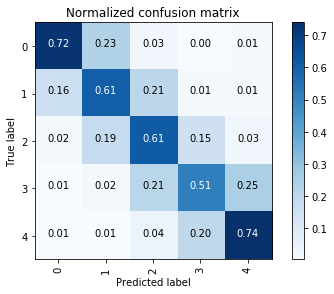

In [57]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
label_names = ['0', '1', '2', '3', '4']
plot_confusion_matrix(conf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')